# Kundur Two Areas

### Import Libraries

In [1]:
import subprocess, sys, os
import urllib.request

dpsim_root_dir = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
sys.path.insert(0, os.path.join(dpsim_root_dir, 'python/src/dpsim/'))
sys.path.insert(0, os.path.join(dpsim_root_dir, 'build'))

import matpower
import dpsimpy
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

### Get simulation data

In [2]:
if not os.path.exists('Kundur2Areas-data'):
    os.mkdir('Kundur2Areas-data')

url_static = 'https://github.com/martinmoraga/dpsim_data/raw/main/Kundur2Areas/matpower/Kundur2Areas.mat'
url_dynamic = 'https://github.com/martinmoraga/dpsim_data/raw/main/Kundur2Areas/matpower/Kundur2Areas_dyn.mat'
local_file_static = './Kundur2Areas-data/Kundur2Areas.mat'
local_file_dynamic = './Kundur2Areas-data/Kundur2Areas_dyn.mat'
urllib.request.urlretrieve(url_static, local_file_static)
urllib.request.urlretrieve(url_dynamic, local_file_dynamic)

('./Kundur2Areas-data/Kundur2Areas_dyn.mat',
 <http.client.HTTPMessage at 0x7e12d012f340>)

### Configure simulation/cosimulation

In [3]:
time_step = 1e-3
t_f = 10
start_fault_time = 0.5
fault_clearing_time = 0.6

switch_closed = 1 # fault resistance
node_fault = "N1"

#  cosimulation parameters
H = 5e-3
interp = 'zoh'
k_map = {'zoh': 0, 'linear': 1}
k = k_map[interp]

cosim_config = {
    "number_topologies": 2,
    "nodes": [["gnd", "N1", "N2", "N5", "N6", "N7", "N8"], ["N3", "N4", "N11", "N10", "N9", "N8"]],
    "eq_component": ["VS", "CS"],
    "split_node": "N8",
    "sim_names": ["DP_Cosim_Kundur2Areas_dyn_S1", "DP_Cosim_Kundur2Areas_dyn_S2"]
}

### 1. Powerflow for initialization

In [4]:
sim_name_pf = 'Kundur2Areas_PF'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_pf)

# read and create dpsim topology
mpc_reader_pf = matpower.Reader(mpc_file_path=local_file_static, mpc_name='Kundur2Areas')
mpc_reader_pf.load_mpc(domain=matpower.Domain.PF)
system_pf = mpc_reader_pf.system

# log results
logger = dpsimpy.Logger(sim_name_pf)
for node in system_pf.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
    logger.log_attribute(node.name()+'.S', 's', node)

# Parametrize and run simulation
sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.info)
sim_pf.set_system(system_pf)
sim_pf.set_time_step(1)
sim_pf.set_final_time(0.1)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.do_init_from_nodes_and_terminals(False)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.add_logger(logger)
sim_pf.run()

/workspaces/dpsim/python/src/dpsim/matpower.py:396: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gen.set_parameters(gen_baseS, gen_baseV, gen_p, gen_v, bus_type, gen_q)
[11:27:32.519170 Kundur2Areas_PF info] Initialize simulation: Kundur2Areas_PF
[11:27:32.519600 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N5
[11:27:32.519607 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N6
[11:27:32.519610 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N7
[11:27:32.519612 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N7
[11:27:32.519616 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N8
[11:27:32.519619 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N9
[11:27:32.519621 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N9
[11:27:32.519624 Kundur2Areas_PF_PF_Solver warning] Unable

### 2. Dynamic, Monolithic simulation

#### Declare some functions

In [5]:
def Kundur2Areas_dyn(domain="SP"):
    if domain=="SP":
        matpower_domain = matpower.Domain.SP
        dpsim_domain = dpsimpy.Domain.SP
    elif domain=="DP":
        matpower_domain = matpower.Domain.DP
        dpsim_domain = dpsimpy.Domain.DP
    else:
        domain="EMT"
        matpower_domain = matpower.Domain.EMT
        dpsim_domain = dpsimpy.Domain.EMT

    sim_name_dyn = domain + "_Kundur2Areas_SS"        
    dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn)

    mpc_reader_dyn = matpower.Reader(mpc_file_path=local_file_static, mpc_name='Kundur2Areas',
                                     mpc_dyn_file_path=local_file_dynamic, mpc_dyn_name='Kundur2Areas_dyn')
    mpc_reader_dyn.create_dpsim_objects(domain=matpower_domain, frequency=60, 
                                     with_avr=False, with_tg=False, with_pss=False)

    ### Extend topology with 3ps fault
    sw = mpc_reader_dyn.add_3ph_faut(node_fault, switch_closed=switch_closed, switch_open=1e18)
    
    # create dpsim topology
    mpc_reader_dyn.create_dpsim_topology()

    #initialize node voltages using pf results
    system_dyn = mpc_reader_dyn.system
    system_dyn.init_with_powerflow(system_pf, dpsim_domain)

    # log results
    logger = dpsimpy.Logger(sim_name_dyn)
    for node in system_dyn.nodes:
        logger.log_attribute(node.name()+'.V', 'v', node)

    # Log line currents
    for line_name in ["line3_7-8", "line4_7-8", "line5_8-9", "line6_8-9"]:
        logger.log_attribute('{}.I'.format(line_name), 'i_intf', mpc_reader_dyn.dpsimpy_comp_dict[line_name][0])

    # Parametrize and run simulation
    sim = dpsimpy.Simulation(sim_name_dyn, dpsimpy.LogLevel.info)
    sim.set_system(system_dyn)
    if domain=="SP":
        sim.set_time_step(1e-3)
    else:
        sim.set_time_step(time_step)
    sim.set_final_time(t_f)
    sim.set_domain(dpsim_domain)
    sim.set_solver(dpsimpy.Solver.MNA)
    sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.KLU)
    sim.do_init_from_nodes_and_terminals(True)
    sim.add_logger(logger)
    sim.do_system_matrix_recomputation(True)

    # add events
    sw_event_1 = dpsimpy.event.SwitchEvent(start_fault_time, sw, True)
    sw_event_2 = dpsimpy.event.SwitchEvent(fault_clearing_time, sw, False)
    sim.add_event(sw_event_1)
    sim.add_event(sw_event_2)
    
    sim.run()
    
    return sim_name_dyn

#### Dpsim Simulations

In [6]:
sim_name_dyn_dp = Kundur2Areas_dyn(domain="DP")

5.000000e-01: Handle event time
6.000000e-01: Handle event time


[11:27:32.617809 DP_Kundur2Areas_SS info] Initialize simulation: DP_Kundur2Areas_SS
[11:27:32.617994 MnaSolverFactory info] creating KLUAdapter solver implementation
[11:27:32.716735 DP_Kundur2Areas_SS info] Scheduling tasks.
[11:27:32.717314 DP_Kundur2Areas_SS info] Scheduling done.
[11:27:32.717318 DP_Kundur2Areas_SS info] Opening interfaces.
[11:27:32.717319 DP_Kundur2Areas_SS info] Start synchronization with remotes on interfaces
[11:27:32.717321 DP_Kundur2Areas_SS info] Synchronized simulation start with remotes
[11:27:32.717323 DP_Kundur2Areas_SS info] Start simulation: DP_Kundur2Areas_SS
[11:27:32.717326 DP_Kundur2Areas_SS info] Time step: 1.000000e-03
[11:27:32.717329 DP_Kundur2Areas_SS info] Final time: 1.000000e+01
[11:27:33.121400 DP_Kundur2Areas_SS info] Simulation calculation time: 0.404017
[11:27:33.121453 DP_Kundur2Areas_SS info] Simulation finished.


### Split topologie at node 8

#### Create topologies for cosimulation

In [7]:
sim_name_fault = "Cosim_Kundur2Areas_Fault"        
dpsimpy.Logger.set_log_dir('logs/' + sim_name_fault)

# load dynamic topology
mpc_reader_dyn = matpower.Reader(mpc_file_path=local_file_static, mpc_name='Kundur2Areas',
                                 mpc_dyn_file_path=local_file_dynamic, mpc_dyn_name='Kundur2Areas_dyn')
mpc_reader_dyn.create_dpsim_objects(domain=matpower.Domain.DP, frequency=60, 
                                 with_avr=False, with_tg=False, with_pss=False)

### Extend topology with 3ps fault
sw = mpc_reader_dyn.add_3ph_faut(node_fault, switch_closed=switch_closed, switch_open=1e18)

# create dpsim topology
mpc_reader_dyn.create_dpsim_topology()

#initialize node voltages using pf results
system_dyn = mpc_reader_dyn.system
system_dyn.init_with_powerflow(system_pf, dpsimpy.Domain.DP)

#create topologies for cosimulation
[sys_topo_1, sys_topo_2] = mpc_reader_dyn.create_cosim_topologies(cosim_config)

In [8]:
#sys_topo_2

#### Prepare 2nd sub topology

In [9]:
sim_name_ss_s2 = cosim_config["sim_names"][1] + '_' + interp + '_' + str(H)
dpsimpy.Logger.set_log_dir('logs/' + sim_name_ss_s2)

# set initial reference current of current source
init_current = sim_pf.get_idobj_attr("line5_8-9", 'current_vector').get()[1][0] + sim_pf.get_idobj_attr("line6_8-9", 'current_vector').get()[1][0]
sys_topo_2.component("CS_N8").set_parameters(init_current * np.sqrt(3))

# log results
logger = dpsimpy.Logger(sim_name_ss_s2)
for node in sys_topo_2.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)

logger.log_attribute(sys_topo_2.component("CS_N8").name()+'.I', 'i_intf', sys_topo_2.component("CS_N8")) 
logger.log_attribute(sys_topo_2.component("CS_N8").name()+'.V', 'v_intf', sys_topo_2.component("CS_N8")) 

# Log line currents
for line_name in ["line5_8-9", "line6_8-9"]:
    logger.log_attribute('{}.I'.format(line_name), 'i_intf', sys_topo_2.component(line_name))

# Parametrize and run simulation
sim2 = dpsimpy.Simulation(sim_name_ss_s2, dpsimpy.LogLevel.info)
sim2.set_system(sys_topo_2)
sim2.set_time_step(time_step)
sim2.set_final_time(t_f)
sim2.set_domain(dpsimpy.Domain.DP)
sim2.set_solver(dpsimpy.Solver.MNA)
sim2.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.KLU)
sim2.do_init_from_nodes_and_terminals(True)
sim2.add_logger(logger)
sim2.do_system_matrix_recomputation(True)

if node_fault in cosim_config["nodes"][1]:
    sw_event_1 = dpsimpy.event.SwitchEvent(start_fault_time, sw, True)
    sw_event_2 = dpsimpy.event.SwitchEvent(fault_clearing_time, sw, False)
    sim2.add_event(sw_event_1)
    sim2.add_event(sw_event_2)
   
sim2.start()

[11:27:33.256928 DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005 info] Initialize simulation: DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005
[11:27:33.257579 MnaSolverFactory info] creating KLUAdapter solver implementation
[11:27:33.272987 DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005 info] Scheduling tasks.
[11:27:33.273290 DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005 info] Scheduling done.
[11:27:33.273293 DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005 info] Opening interfaces.
[11:27:33.273295 DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005 info] Start synchronization with remotes on interfaces
[11:27:33.273296 DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005 info] Synchronized simulation start with remotes
[11:27:33.273297 DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005 info] Start simulation: DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005
[11:27:33.273300 DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005 info] Time step: 1.000000e-03
[11:27:33.273303 DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005 info] Final time: 1.000000e+01


#### Prepare 1st sub topology

In [10]:
sim_name_ss_s1 = cosim_config["sim_names"][0] + '_' + interp + '_' + str(H)
dpsimpy.Logger.set_log_dir('logs/' + sim_name_ss_s1)

# set initial current of voltage source
init_current = sim_pf.get_idobj_attr("line3_7-8", 'current_vector').get()[0][0] + sim_pf.get_idobj_attr("line4_7-8", 'current_vector').get()[0][0]
sys_topo_1.component("VS_N8").set_intf_current([-init_current * np.sqrt(3)])

# set parameters of voltage source
init_voltage = sim_pf.get_idobj_attr("N8", 'v').get()[0]
sys_topo_1.component("VS_N8").set_parameters(init_voltage)

# log results
logger = dpsimpy.Logger(sim_name_ss_s1)
for node in sys_topo_1.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)

logger.log_attribute(sys_topo_1.component("VS_N8").name()+'.I', 'i_intf', sys_topo_1.component("VS_N8")) 
logger.log_attribute(sys_topo_1.component("VS_N8").name()+'.V', 'v_intf', sys_topo_1.component("VS_N8")) 

for line_name in ["line3_7-8", "line4_7-8"]:
    logger.log_attribute('{}.I'.format(line_name), 'i_intf', sys_topo_1.component(line_name))

# Parametrize and run simulation
sim1 = dpsimpy.Simulation(sim_name_ss_s1, dpsimpy.LogLevel.info)
sim1.set_system(sys_topo_1)
sim1.set_time_step(time_step)
sim1.set_final_time(t_f)
sim1.set_domain(dpsimpy.Domain.DP)
sim1.set_solver(dpsimpy.Solver.MNA)
sim1.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.KLU)
sim1.do_init_from_nodes_and_terminals(True)
sim1.add_logger(logger)
sim1.do_system_matrix_recomputation(True)

# add events
if node_fault in cosim_config["nodes"][0]:
    sw_event_1 = dpsimpy.event.SwitchEvent(start_fault_time, sw, True)
    sw_event_2 = dpsimpy.event.SwitchEvent(fault_clearing_time, sw, False)
    sim1.add_event(sw_event_1)
    sim1.add_event(sw_event_2)

sim1.start()
y_1_0 = sim1.get_idobj_attr("VS_N8", "i_intf").get()[0]

/tmp/ipykernel_538343/1223469137.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sys_topo_1.component("VS_N8").set_parameters(init_voltage)
[11:27:33.286491 DP_Cosim_Kundur2Areas_dyn_S1_zoh_0.005 info] Initialize simulation: DP_Cosim_Kundur2Areas_dyn_S1_zoh_0.005
[11:27:33.286717 MnaSolverFactory info] creating KLUAdapter solver implementation
[11:27:33.295237 DP_Cosim_Kundur2Areas_dyn_S1_zoh_0.005 info] Scheduling tasks.
[11:27:33.295569 DP_Cosim_Kundur2Areas_dyn_S1_zoh_0.005 info] Scheduling done.
[11:27:33.295572 DP_Cosim_Kundur2Areas_dyn_S1_zoh_0.005 info] Opening interfaces.
[11:27:33.295573 DP_Cosim_Kundur2Areas_dyn_S1_zoh_0.005 info] Start synchronization with remotes on interfaces
[11:27:33.295574 DP_Cosim_Kundur2Areas_dyn_S1_zoh_0.005 info] Synchronized simulation start with remotes
[11:27:33.29557

In [11]:
#sys_topo_1

#### Execute cosimulation

In [12]:
t_0 = 0
t_k_v = []
j_v = []
t_k = 0.0
y_1 = y_1_0

print(y_1)

n = int(round((t_f - t_0) / time_step))
t = np.around(np.linspace(t_0, t_f, n + 1), 16)

m = int(np.around(H/time_step))
print("m = " + str(m))

N = int(round((t_f - t_0) / H))
t_m = np.around(np.linspace(t_0, t_f, N + 1), 16)

# We have to assume the trajectory of y_2 extending its initial value, since we have no prior information
# y_1_m_prev = np.tile(y_1_0, np.max([k, m]))
y_1_m_prev = np.tile(y_1_0, np.min([k+1, m]))

for i in range(0, N):   
    y_1_prev = y_1_m_prev[-1]
    t_m_i = t[m*i + 1: m*(i+1) + 1]

    if interp == 'zoh':
        u_2_m = np.tile(y_1_prev, m)
    elif interp == 'linear':
        y_1_m_prev_r = np.real(y_1_m_prev[-2:])
        y_1_m_prev_i = np.imag(y_1_m_prev[-2:])
        f_u_2_r = np.poly1d(np.polyfit([i*H-H, i*H], y_1_m_prev_r, 1))
        f_u_2_i = np.poly1d(np.polyfit([i*H-H, i*H], y_1_m_prev_i, 1))
        u_2_m_r = f_u_2_r(t_m_i)
        u_2_m_i = f_u_2_i(t_m_i)

        u_2_m = u_2_m_r + 1j * u_2_m_i

    y_1_m = np.zeros(m, dtype=complex)

    for j in range(0, m):
        # Switch to S_2                
        u_2 = u_2_m[j]

        sim2.get_idobj_attr("CS_N8", "I_ref").set(u_2)

        sim2.next()
        y_2 = sim2.get_idobj_attr("CS_N8", "v_intf").get()[0]
        u_1 = y_2[0]

        sim1.get_idobj_attr("VS_N8", "V_ref").set(u_1)
        t_k = sim1.next()
        y_1 = sim1.get_idobj_attr("VS_N8", "i_intf").get()[0]

        y_1_m[j] = y_1[0]
        # j += 1
        t_k_v.append(t_k)

    # Option 1: Take values at macrosteps as samples for extrapolation
    y_1_m_prev = np.append(y_1_m_prev, y_1_m[-1])

    # Option 2: Take values at microsteps as samples for extrapolation
    # y_1_m_prev = y_1_m
    
    # j_v.append(j)

    if t_k > t_f:
        print(t_k)
        print("i: " + str(i) + ", expected: " + str(N-1))
        print("j: " + str(j) + ", expected: " + str(m-1))
        break

sim1.stop()
sim2.stop()

[1798.77364544-146.38514716j]
m = 5
5.000000e-01: Handle event time
6.000000e-01: Handle event time
10.000999999999896
i: 1999, expected: 1999
j: 4, expected: 4


[11:27:34.184261 DP_Cosim_Kundur2Areas_dyn_S1_zoh_0.005 info] Simulation calculation time: 0.888643
[11:27:34.184467 DP_Cosim_Kundur2Areas_dyn_S1_zoh_0.005 info] Simulation finished.
[11:27:34.184694 DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005 info] Simulation calculation time: 0.911358
[11:27:34.184844 DP_Cosim_Kundur2Areas_dyn_S2_zoh_0.005 info] Simulation finished.


### Compare steady state results

In [13]:
from villas.dataprocessing.timeseries import TimeSeries as ts
import villas.dataprocessing.plottools as pt

dpsim_result_file_ss = 'logs/' + sim_name_dyn_dp + '/' + sim_name_dyn_dp + '.csv'
ts_dpsim_fault_dp = read_timeseries_csv(dpsim_result_file_ss)

dpsim_result_file_ss_s1 = 'logs/' + sim_name_ss_s1 + '/' + sim_name_ss_s1 + '.csv'
ts_dpsim_fault_s1_dp = read_timeseries_csv(dpsim_result_file_ss_s1)

dpsim_result_file_ss_s2 = 'logs/' + sim_name_ss_s2 + '/' + sim_name_ss_s2 + '.csv'
ts_dpsim_fault_s2_dp = read_timeseries_csv(dpsim_result_file_ss_s2)

column number: 16
results length: 10001
real column names: []
complex column names: ['N1.V', 'N10.V', 'N11.V', 'N2.V', 'N3.V', 'N4.V', 'N5.V', 'N6.V', 'N7.V', 'N8.V', 'N9.V', 'gnd.V', 'line3_7-8.I', 'line4_7-8.I', 'line5_8-9.I', 'line6_8-9.I']
column number: 11
results length: 10001
real column names: []
complex column names: ['N1.V', 'N2.V', 'N5.V', 'N6.V', 'N7.V', 'N8.V', 'VS_N8.I', 'VS_N8.V', 'gnd.V', 'line3_7-8.I', 'line4_7-8.I']
column number: 10
results length: 10001
real column names: []
complex column names: ['CS_N8.I', 'CS_N8.V', 'N10.V', 'N11.V', 'N3.V', 'N4.V', 'N8.V', 'N9.V', 'line5_8-9.I', 'line6_8-9.I']


### Define plot functions

In [14]:
timestep_common = H
t_begin = 0.0
t_end = t_f
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

#plot parameters
width = 8
height = 4

def plot_node_volt_abs(varname_dpsim, 
                       ts_dpsim_emt, ts_dpsim_emt_s1, ts_dpsim_emt_s2, nominal_voltage, timestep_common=1e-3, y_lim=False):
    
    #convert dpsim voltage to magnitude value and per-unit for comparison with psat
    dpsim_emt_values_s1 = np.abs(ts_dpsim_emt_s1[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]) / nominal_voltage
    dpsim_emt_values_s2 = np.abs(ts_dpsim_emt_s2[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]) / nominal_voltage
    dpsim_emt_values = np.abs(ts_dpsim_emt[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]) / nominal_voltage
    
    plt.figure(figsize=(width, height))
    # plt.subplot(1, 2, 1)
    plt.plot(time, dpsim_emt_values_s1, label='DP - S1')
    plt.plot(time, dpsim_emt_values_s2, '--', label='DP - S2')
    plt.plot(time, dpsim_emt_values, '--', label='DP - Monolithic')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.grid()
    #plt.ylim([1.058, 1.062])
    # plt.xlim([0.95, 1.2])
    plt.xlim([0, 10])
    plt.xlabel("time (s)")
    plt.ylabel(varname_dpsim + " (pu)")
    if (y_lim):
        plt.ylim(y_lim)
    
    # plt.subplot(1, 2, 2)
    # plt.plot(time, dpsim_emt_values, ':', label='EMT - DPsim')
    # plt.legend(loc='lower right')
    # plt.xlabel('time (s)')
    # plt.grid()
    # #plt.ylim([1.058, 1.062])
    # # plt.xlim([2.9, 3.1])
    # plt.xlabel("time (s)")
    # plt.ylabel(varname_dpsim + " (pu)")
    # if (y_lim):
    #     plt.ylim(y_lim)
        
    # plt.savefig('Kundur2Areas_dyn_DP_cosim_attributes_fault_{}.svg'.format(varname_dpsim))
    plt.show()
    
    #calculate RMSE
    #rmse = np.sqrt(((dpsim_sp_values_abs_pu - psat_values) ** 2).mean())
    #print('RMSE {:s}  = {:.6f} (pu), which is {:.3f}% of the nominal value = {:.3f} (pu) '.format(varname_dpsim, rmse, rmse/1.0*100, 1.0))
    
def plot_power_area12(varname_dpsim, 
                       ts_dpsim_mon, ts_dpsim_s1, ts_dpsim_s2, nominal_voltage, timestep_common=1e-3, y_lim=False):
    
    # calculate power flow throw lines 7-8
    power_line3_mon = np.conjugate(ts_dpsim_mon["line3_7-8.I"].interpolate(timestep_common).values) * ts_dpsim_mon["N7.V"].interpolate(timestep_common).values
    power_line4_mon = np.conjugate(ts_dpsim_mon["line4_7-8.I"].interpolate(timestep_common).values) * ts_dpsim_mon["N7.V"].interpolate(timestep_common).values
    power_line5_mon = np.conjugate(ts_dpsim_mon["line5_8-9.I"].interpolate(timestep_common).values) * ts_dpsim_mon["N8.V"].interpolate(timestep_common).values
    power_line6_mon = np.conjugate(ts_dpsim_mon["line6_8-9.I"].interpolate(timestep_common).values) * ts_dpsim_mon["N8.V"].interpolate(timestep_common).values
    power_line3_s1 = np.conjugate(ts_dpsim_s1["line3_7-8.I"].interpolate(timestep_common).values) * ts_dpsim_s1["N7.V"].interpolate(timestep_common).values
    power_line4_s1 = np.conjugate(ts_dpsim_s1["line4_7-8.I"].interpolate(timestep_common).values) * ts_dpsim_s1["N7.V"].interpolate(timestep_common).values
    power_line5_s2 = np.conjugate(ts_dpsim_s2["line5_8-9.I"].interpolate(timestep_common).values) * ts_dpsim_s1["N8.V"].interpolate(timestep_common).values
    power_line6_s2 = np.conjugate(ts_dpsim_s2["line6_8-9.I"].interpolate(timestep_common).values) * ts_dpsim_s1["N8.V"].interpolate(timestep_common).values

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 6))

    axes[0].plot(ts_dpsim_s1["line3_7-8.I"].interpolate(timestep_common).time, (power_line3_s1 + power_line4_s1) * 1e-6, label='DP S1')
    axes[0].plot(ts_dpsim_mon["line3_7-8.I"].interpolate(timestep_common).time, (power_line3_mon + power_line4_mon) * 1e-6, '--', label='DP - Monolithic')
    axes[0].legend(loc='lower right')
    axes[0].set_xlabel('Time [s]')
    axes[0].set_ylabel('Active power flow \nBus 7-8 [MW]')
    #axes[0].set_ylim([0, 10])
    axes[0].set_xlim([0, 10])
    axes[0].grid()

    axes[1].plot(ts_dpsim_s2["line5_8-9.I"].interpolate(timestep_common).time, (power_line5_s2 + power_line6_s2) * 1e-6, label='DP S2')
    axes[1].plot(ts_dpsim_mon["line4_7-8.I"].interpolate(timestep_common).time, (power_line5_mon + power_line6_mon) * 1e-6, '--', label='DP - Monolithic')
    axes[1].legend(loc='lower right')
    axes[1].set_xlabel('Time [s]')
    axes[1].set_ylabel('Active power flow \nBus 8-9 [MW]')
    axes[1].set_xlim([0, 10])
    axes[1].grid()

    #fig.tight_layout()
    #fig.savefig("./plotting/ActivePowerExchange_Area1-2.pdf")

#### Inteface node

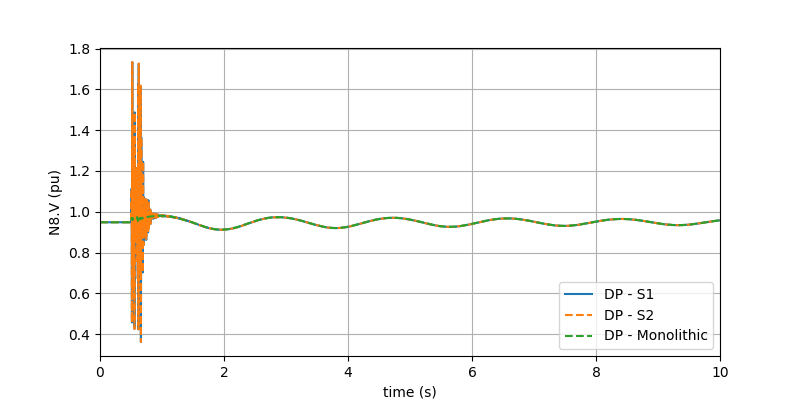

In [15]:
varname_dpsim = 'N8.V'
nominal_voltage = 230000
plot_node_volt_abs(varname_dpsim, ts_dpsim_fault_dp, ts_dpsim_fault_s1_dp, ts_dpsim_fault_s2_dp, nominal_voltage, timestep_common)

/usr/local/lib64/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib64/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


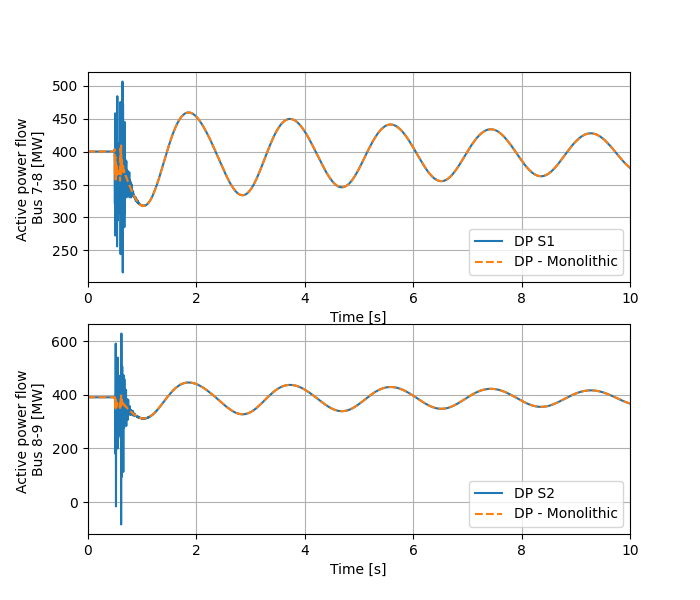

In [16]:
varname_dpsim = 'N8.V'
nominal_voltage = 230000
plot_power_area12(varname_dpsim, ts_dpsim_fault_dp, ts_dpsim_fault_s1_dp, ts_dpsim_fault_s2_dp, nominal_voltage, timestep_common)